In [5]:
import numpy as np 
import matplotlib.pyplot as plt


In [47]:
def Wendland_kern(x1, x2, epsilon = 0.001): #kernel, use Wendland covariance as an example 
        return np.max(1 - np.abs(x1 - x2)/epsilon, 0)**4 * (4*np.abs(x1 - x2)/epsilon + 1)

def gauss_kernel(x1, x2, L= 0.5):
    return np.exp(-(x1-x2)**2 / (2* L**2))

def gauss_kernel_derix(x1, x2, L = 0.5):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (- (x1 - x2) / L**2)

def gauss_kernel_derixy(x1, x2, L = 0.5):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  + L**2)

def gauss_kernel_derixx(x1, x2, L = 0.5):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  - L**2)

def gauss_kernel_deri2yy(x1, x2, L = 0.5):
    return gauss_kernel_derixx(x1, x2, L) 

def K(X, Y, kern):  #X, T are both list 
        output = np.zeros((len(X), len(Y)))
        for i in range(len(X)):
            for j in range(len(Y)):
                output[i-1][j-1] = kern(X[i], Y[j]) 

        return output 

g1 =  lambda x: np.cos(2*np.pi*x)
b1 = lambda x: x 

B1 = lambda x: x

d1, d2 = 0, 1
D1, D2 = 0, 1

In [37]:
X_A, X_B = [0.1*i for i in range(1, 10)], [0.1*i for i in range(1, 10)]
X = [0.2*i for i in range(1, 10)]

In [44]:
B = B1
AA_hat = gauss_kernel_derixy
AB_hat_K = gauss_kernel_derix
BA_hat_K = gauss_kernel_derix

In [68]:
LK = np.vstack((K(X_A, X, gauss_kernel_derix), K(X_B,X,gauss_kernel))) #LK 

In [70]:
L_hat_K = np.hstack((K(X, X_A, gauss_kernel_derix), K(X, X_B, gauss_kernel)))

In [76]:
LL_hat_K = np.vstack((np.hstack((K(X_A, X_A, gauss_kernel_derixy), K(X_A, X_B, gauss_kernel_derix))), np.hstack((K(X_B, X_A,gauss_kernel_derix), K(X_B, X_B, gauss_kernel)))))

In [79]:
def g_matrix(g, X):
        return np.array([np.vectorize(g)(X)]).T

def b_matrix(b, X):
        return np.array([np.vectorize(b)(X)]).T

In [81]:
g_matrix(g1, X_A), b_matrix(b1, X_B)

(array([[ 0.80901699],
        [ 0.30901699],
        [-0.30901699],
        [-0.80901699],
        [-1.        ],
        [-0.80901699],
        [-0.30901699],
        [ 0.30901699],
        [ 0.80901699]]),
 array([[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]))

In [91]:
latter = np.hstack((g_matrix(g1, X_A).T, b_matrix(b1, X_B).T)).T
latter.shape

(18, 1)

In [93]:
middle = np.linalg.inv(LL_hat_K)
mean = np.matmul(np.matmul(L_hat_K, middle), latter)
mean

array([[2.99997779e-01],
       [4.99997526e-01],
       [6.99999467e-01],
       [1.49774915e+00],
       [1.71969618e+01],
       [9.22506718e+01],
       [2.44865173e+02],
       [3.96852178e+02],
       [9.99965745e-02]])

In [95]:
var = K(X, X, gauss_kernel)  - np.matmul(np.matmul(L_hat_K, middle), LK)

In [97]:
var

array([[ 7.38246933e-06,  7.48079668e-06,  6.54663495e-06,
         4.94109686e-06,  3.21173097e-06,  1.79532304e-06,
         8.61874313e-07,  3.54906144e-07,  6.29930854e-06],
       [ 7.32687794e-06,  7.23987457e-06,  6.10987155e-06,
         4.38953991e-06,  2.67414679e-06,  1.37453907e-06,
         5.92069648e-07,  2.11556744e-07,  6.35003321e-06],
       [ 8.55865716e-07,  1.01741787e-06,  9.65438092e-07,
         7.43669923e-07,  4.66836454e-07,  2.37439197e-07,
         9.60206699e-08,  2.94392256e-08,  5.49424839e-07],
       [-2.53210119e-06, -2.39780565e-06, -2.01966121e-06,
        -1.52146950e-06, -1.17259754e-06, -1.30985900e-06,
        -1.16491617e-06,  1.13711017e-06, -2.36467913e-06],
       [-4.33411752e-06, -4.37958676e-06, -3.80707196e-06,
        -2.99960106e-06, -4.34487501e-06,  5.23321414e-06,
         1.04455949e-04,  3.79527182e-04, -3.70221739e-06],
       [-6.73174743e-06, -6.92979523e-06, -6.13367483e-06,
        -5.37411489e-06,  3.18238942e-06,  2.897666

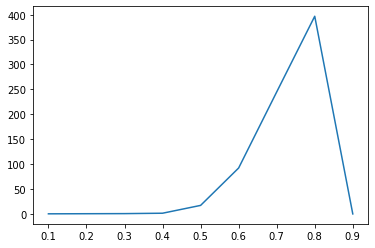

In [103]:
plt.plot(X_A, mean)

In [ ]:
np.random.multivariate_normal(mean, var, (3, 3))

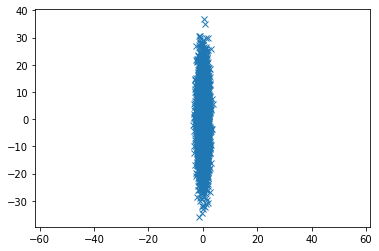

In [104]:
mean1 = [0, 0]
cov1 = [[1, 0], [0, 100]] 

x, y = np.random.multivariate_normal(mean1, cov1, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()